# Data Summary Statictics

## Imports

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import tqdm.auto as tqdm

import os
from PIL import Image
from sklearn.metrics import accuracy_score
import torchvision
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

plt.style.use('seaborn')

## Missing data observations

In [3]:
dermx_labels = pd.read_csv('./data/dermx_labels.csv')
dermx_labels.groupby('diagnosis').size()

# Transform the labels.
le = LabelEncoder().fit(dermx_labels['diagnosis'].tolist())
dermx_labels['target'] = le.transform(dermx_labels['diagnosis'])

# Write up the image path.
dermx_labels['path'] = dermx_labels['image_id'].apply(lambda x : os.path.join('data', 'images', f'{x}.jpeg'))

# Drop images that could not be found.
n_before = len(dermx_labels)

dermx_labels = dermx_labels.loc[dermx_labels['path'].apply(lambda x : os.path.exists(x))]

n_after  = len(dermx_labels)

print(f'Observations before: {n_before}')
print(f'Observations after: {n_after}')

assert n_after > 0, 'Images could not be found. Make sure you have unpacked images into ./data/images/'

Observations before: 492
Observations after: 453


## Image sizes

In [4]:
# Simple Dataset playground creator

class DiagnosisDataset(Dataset):
    '''
    Define our dataset
    '''
    def __init__(self, path, target, transforms = torch.nn.Sequential()):
        #Input:
        # path:   path to the images.
        # target: target diagnosis.
        
        assert len(path) == len(target), 'path and target should be the same length.'
        
        self.path   = path
        self.target = target
        self.transforms = transforms
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, idx):
        path   = self.path[idx]
        target = self.target[idx]
        
        #Load the image
        im = Image.open(path)
        im = np.array(im) #4th channel is alpha.
        im = torch.tensor(im, dtype=torch.float32).permute(2,0,1) / 255.
        
        if self.transforms is not None:
            im = self.transforms(im)
            
        return im, target, path

In [5]:
entire_dataset = DiagnosisDataset(dermx_labels['path'].tolist(), dermx_labels['target'].tolist())

sizes = []
for i in tqdm.tqdm(range(len(entire_dataset)), desc='Loading in the dataset'):
    im, target, path = entire_dataset.__getitem__(i)
    sizes.append([im.shape[1], im.shape[2]])
    
sizes = pd.DataFrame(np.array(sizes), columns = ['nrow', 'ncol'])
sizes_count = sizes.groupby(['nrow', 'ncol']).size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)
count_totals = list(sizes_count['count'].drop_duplicates())

Loading in the dataset: 100%|██████████| 453/453 [00:23<00:00, 19.28it/s]


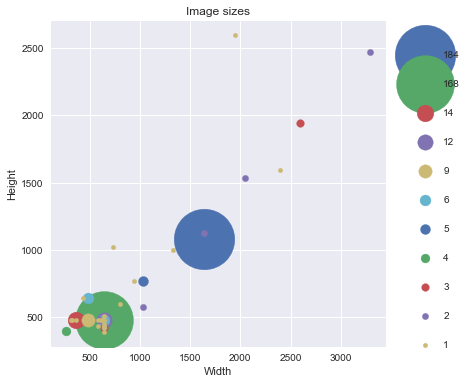

In [77]:
plt.figure(figsize=(6,6))
for c in count_totals:
    sizes_count_c = sizes_count[sizes_count['count'] == c]
    plt.scatter(sizes_count_c['ncol'], sizes_count_c['nrow'], s=c*20, alpha=1, label=c)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.45), labelspacing=2)
plt.title('Image sizes')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

## Characteristics

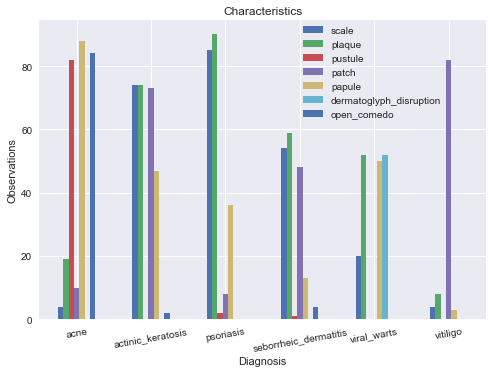

In [209]:
variables = ['diagnosis','scale','plaque','pustule','patch','papule','dermatoglyph_disruption','open_comedo']
dermx_labels['open_comedo'] = dermx_labels['open_comedo'].apply(lambda x: 1 if x > 0 else 0)
d = dermx_labels[variables].groupby('diagnosis').sum()

ax  = d.plot.bar(rot=10, title='Characteristics')
ax.set_xlabel("Diagnosis")
ax.set_ylabel("Observations")
ax.legend(bbox_to_anchor=(0.57, 0.64))

## Area counts

<AxesSubplot:title={'center':'Areas'}>

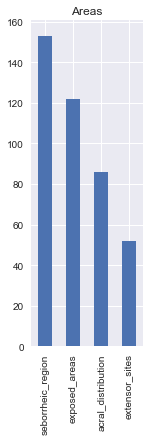

In [194]:
plt.figure(figsize=(2,6))
dermx_labels['area'].value_counts().plot.bar(rot=90,title="Areas")

## Diagnosis counts

<AxesSubplot:title={'center':'Diagnosis'}>

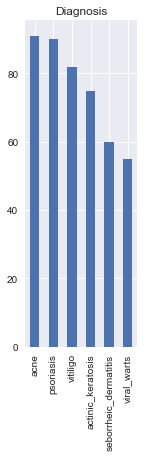

In [197]:
plt.figure(figsize=(2,6))
dermx_labels['diagnosis'].value_counts().plot.bar(rot=90,title="Diagnosis")